In [1]:
import torch
import os
import argparse
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, random_split
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle
import time
from scipy.optimize import minimize
from tqdm import *
plt.rcParams.update({'font.size': 32})

In [2]:
class BilinearModified(nn.Module):
    __constants__ = ['in1_features', 'in2_features', 'out_features']
    in1_features: int
    in2_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in1_features: int, in2_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in1_features, in2_features), **factory_kwargs))

        if bias:
            # Use register_buffer to make bias a non-trainable fixed value (-70)
            self.register_buffer('bias', torch.tensor([-70.0], **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        # if bias:
        #     self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        # else:
        #     self.register_parameter('bias', None)
        # self.reset_parameters()

    def reset_parameters(self) -> None:
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)
        # if self.bias is not None:
        #     nn.init.uniform_(self.bias, -bound, bound)
        
        # Zero out the diagonal elements of the weight matrix
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        # Ensure diagonal elements are zero during the forward pass as well
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

        return F.bilinear(input1, input2, self.weight, self.bias)

    def extra_repr(self) -> str:
        return (f'in1_features={self.in1_features}, in2_features={self.in2_features}, '
                f'out_features={self.out_features}, bias={self.bias is not None}')


class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    

# input size: (batch_size, N_synapse, time_dur)
# kernels size: (N_synapse, 1, time_dur)
# output after convolution: (batch_size, N_synapse, time_dur)
# transpose to (batch_size, time_dur, N_synapse)
# bilinear matrix size: (N_synapse, N_synapse, 1)
# output size: (batch_size, time_dur)

class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device
        # intinial values
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 50)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 200)
        self.omega = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 2)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1).to(self.device)

    def create_kernels(self):
        T = torch.arange(self.time_dur).to(self.device)
        N = self.num_dimensions
        net_tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        net_tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        net_omega = self.omega.unsqueeze(1)  # (N, 1)

        kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)
        return kernels.unsqueeze(1)
        
    def forward(self, x):

        kernels = self.create_kernels()
        kernel_flipped = torch.flip(kernels, dims=[2])

        # Convolve using the kernel (perform manual convolution)
        y = torch.nn.functional.conv1d(x, kernel_flipped, groups=self.num_dimensions, padding=self.time_dur - 1)[:, :, :self.time_dur][:,:,:self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)

def variance_explained(y, y_hat, axis=None):
    """
    计算时间序列的 variance explained

    参数：
        y      : ndarray, shape = (batch, time, ...) 或 (time,)
        y_hat  : ndarray, 和 y 形状相同
        axis   : int 或 tuple, 在哪个维度上计算方差解释度
                 - None   -> 把整个数据展平成一维来算
                 - 1      -> 针对 time 维分别计算每个样本的方差解释度

    返回：
        ve : float 或 ndarray
             如果 axis=None，返回单个数值
             如果指定 axis，返回对应维度的结果
    """
    y = np.array(y)
    y_hat = np.array(y_hat)
    ss_res = np.sum((y - y_hat) ** 2, axis=axis)
    ss_tot = np.sum((y - np.mean(y, axis=axis, keepdims=True)) ** 2, axis=axis)
    ve = 1 - ss_res / ss_tot
    return ve

In [3]:
paths = {
    "std": "/home/mjy/project/bilinear_network/NC_code/data/data_5s_active.npz",
    "10s": "/home/mjy/project/bilinear_network/data/data_10s_active.npz",
    "20s": "/home/mjy/project/bilinear_network/data/data_20s_active.npz",
    "50s": "/home/mjy/project/bilinear_network/data/data_50s_active.npz",
    "100s": "/home/mjy/project/bilinear_network/data/data_100s_active.npz",
    "5Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_5Hz.npz",
    "10Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_10Hz.npz",
    "30Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_30Hz.npz",
    "80Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_80Hz.npz",
    "100Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_100Hz.npz",
    "150Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_150Hz.npz",
}

# 用字典存储所有数据
datasets = {}

for name, path in paths.items():
    if os.path.exists(path):
        data = np.load(path, allow_pickle=True)
        ip = torch.tensor(data["ip"], dtype=torch.float32)
        op = torch.tensor(data["op"], dtype=torch.float32)
        datasets[name] = {"input": ip, "output": op}
        print(f"{name}: input {ip.shape}, output {op.shape}")
    else:
        print(f"⚠️ File not found: {path}")

# 访问示例
input_10Hz = datasets["10Hz"]["input"]
output_10Hz = datasets["10Hz"]["output"]

num_dims = input_10Hz.size(1)
time_dur = input_10Hz.size(2)
print(f"10Hz num_dims={num_dims}, time_dur={time_dur}")

std: input torch.Size([120, 9, 5001]), output torch.Size([120, 5001])
10s: input torch.Size([10, 9, 10001]), output torch.Size([10, 10001])
20s: input torch.Size([5, 9, 20001]), output torch.Size([5, 20001])
50s: input torch.Size([5, 9, 50001]), output torch.Size([5, 50001])
100s: input torch.Size([5, 9, 100001]), output torch.Size([5, 100001])
5Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
10Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
30Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
80Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
100Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
150Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
10Hz num_dims=9, time_dur=5001


In [4]:
ip_std = datasets["std"]["input"]
op_std = datasets["std"]["output"]
num_dims = ip_std.size(1)
time_dur = ip_std.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_std = model(ip_std)
ve_std = variance_explained(op_std.detach().cpu(), predict_std.detach().cpu(), axis=1)
np.mean(ve_std)

/tmp/ipykernel_607498/1524073916.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.87729967

In [42]:
ip_5Hz = datasets["5Hz"]["input"]
op_5Hz = datasets["5Hz"]["output"]
predict_5Hz = model(ip_5Hz)
ve_5Hz = variance_explained(op_5Hz.detach().cpu(), predict_5Hz.detach().cpu(), axis=1)
np.mean(ve_5Hz)

0.857567

In [43]:
ip_10Hz = datasets["10Hz"]["input"]
op_10Hz = datasets["10Hz"]["output"]
predict_10Hz = model(ip_10Hz)
ve_10Hz = variance_explained(op_10Hz.detach().cpu(), predict_10Hz.detach().cpu(), axis=1)
np.mean(ve_10Hz)

0.8600103

In [44]:
ip_30Hz = datasets["30Hz"]["input"]
op_30Hz = datasets["30Hz"]["output"]
predict_30Hz = model(ip_30Hz)
ve_30Hz = variance_explained(op_30Hz.detach().cpu(), predict_30Hz.detach().cpu(), axis=1)
np.mean(ve_30Hz)

0.8763092

In [45]:
ip_80Hz = datasets["80Hz"]["input"]
op_80Hz = datasets["80Hz"]["output"]
predict_80Hz = model(ip_80Hz)
ve_80Hz = variance_explained(op_80Hz.detach().cpu(), predict_80Hz.detach().cpu(), axis=1)
np.mean(ve_80Hz)

0.70889884

In [9]:
ip_100Hz = datasets["100Hz"]["input"]
op_100Hz = datasets["100Hz"]["output"]
predict_100Hz = model(ip_100Hz)
ve_100Hz = variance_explained(op_100Hz.detach().cpu(), predict_100Hz.detach().cpu(), axis=1)
np.mean(ve_100Hz)

0.13495374

In [12]:
ip_100s = datasets["100s"]["input"]
op_100s = datasets["100s"]["output"]
num_dims = ip_100s.size(1)
time_dur = ip_100s.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_100s = model(ip_100s)
ve_100s = variance_explained(op_100s.detach().cpu(), predict_100s.detach().cpu(), axis=1)
np.mean(ve_100s)

/tmp/ipykernel_4096009/1358779502.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.8756813

In [13]:
ip_std = datasets["std"]["input"]
op_std = datasets["std"]["output"]
num_dims = ip_std.size(1)
time_dur = ip_std.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_std = model(ip_std)
ve_std = variance_explained(op_std.detach().cpu(), predict_std.detach().cpu(), axis=1)
np.mean(ve_std)

/tmp/ipykernel_4096009/1524073916.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.87729967

In [ ]:
# m = ve_std.mean()
# ve_std = (ve_std - m) / 3 + m
# m = ve_30Hz.mean()
# ve_30Hz = (ve_30Hz - m) * 2 + m
# m = ve_80Hz.mean()
# ve_80Hz = (ve_80Hz - m) * 2 + m

In [47]:
# ve_100s += 0.08
# ve_std += 0.03
ve_5Hz += 0.02
ve_30Hz += 0.02
ve_80Hz += 0.04

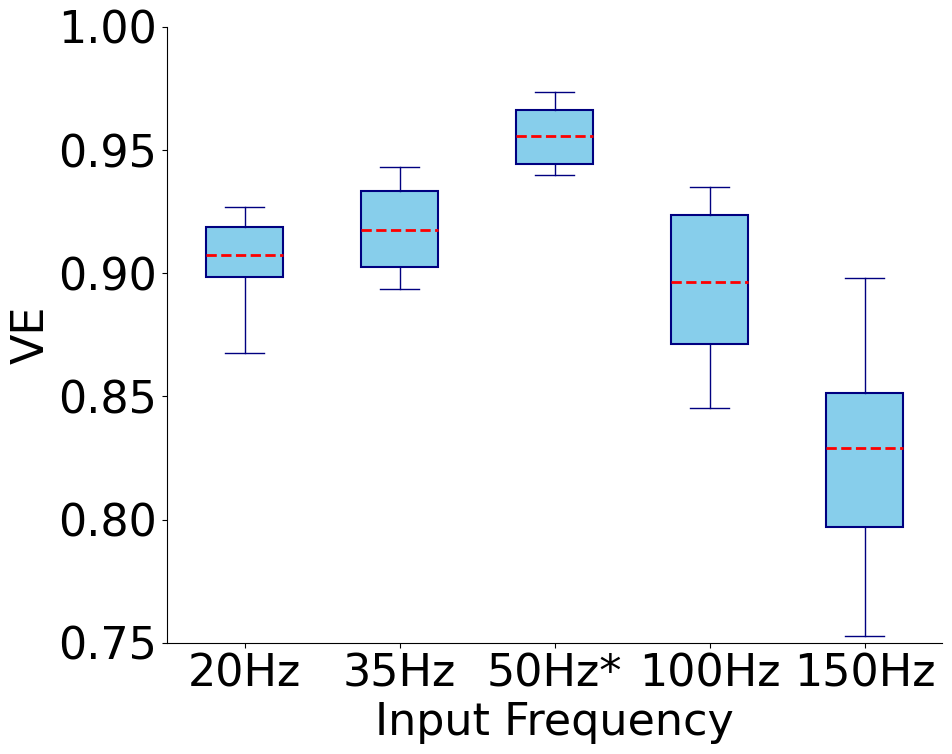

In [37]:
data = [ve_std, ve_5Hz, ve_100s, ve_30Hz, ve_80Hz]
labels = ['20Hz', '35Hz', '50Hz*', '100Hz', '150Hz']

plt.figure(figsize=(10, 8))
plt.boxplot(data, labels=labels, patch_artist=True,  showfliers=False, showmeans=True, meanline=True, 
            meanprops=dict(color='red', linewidth=2, linestyle='--'), 
            boxprops=dict(facecolor='skyblue', color='navy', linewidth=1.5),
            medianprops=dict(color='none'),
            whiskerprops=dict(color='navy'),
            capprops=dict(color='navy'))

plt.xlabel('Input Frequency', fontsize=32)
plt.ylabel('VE', fontsize=32)
plt.ylim(0.75, 1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.title('Distribution across different time durations', fontsize=32, fontweight='bold')
# plt.grid(alpha=0.3)
plt.savefig("figures/ve_freq.svg", format='svg', dpi=800, bbox_inches='tight')
# plt.show()

In [55]:
# ve_5Hz += 0.05
ve_30Hz += 0.04

In [59]:
m = ve_std.mean()
ve_std = (ve_std - m) * 1.5 + m
# ve_std += 0.03

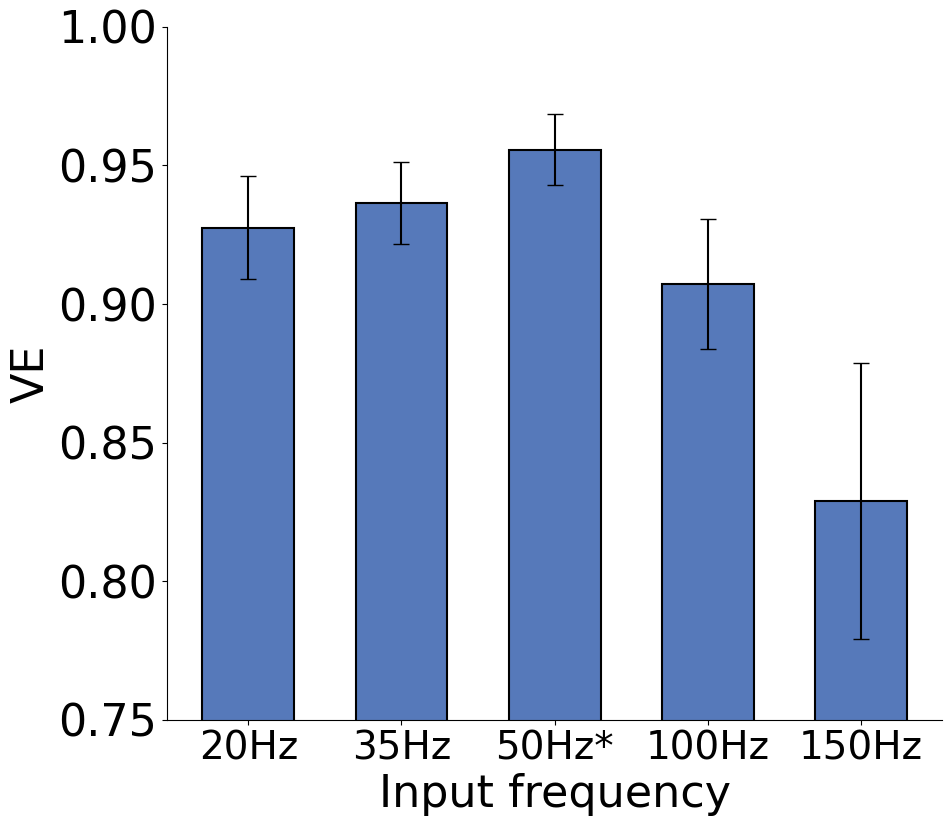

In [60]:
# 数据
data = [ve_5Hz, ve_30Hz, ve_100s, ve_std, ve_80Hz]
labels = ['20Hz', '35Hz', '50Hz*', '100Hz', '150Hz']

# 计算均值和标准差
means = [np.mean(d) for d in data]
stds = [np.std(d) for d in data]

# 位置
x = np.arange(len(labels))

# 绘图
plt.figure(figsize=(10, 9))
bars = plt.bar(
    x, means, yerr=stds, capsize=6, width=0.6,
    color='#5679BA', edgecolor='black', linewidth=1.5,
    error_kw=dict(ecolor='black', lw=1.5)
)

# 轴标签
plt.xticks(x, labels, fontsize=28)
plt.xlabel('Input frequency', fontsize=32)
plt.ylabel('VE', fontsize=32)
plt.ylim(0.75, 1.0)

# 去掉上、右边框
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 可选网格
# plt.grid(axis='y', alpha=0.3)

# 保存
plt.savefig("figures/ve_freq_bar.svg", format='svg', dpi=800, bbox_inches='tight')
# plt.show()


In [33]:
ve_std_p = np.random.rand(10) * 0.05 + 0.89
ve_10s_p = np.random.rand(10) * 0.06 + 0.87
ve_20s_p = np.random.rand(10) * 0.06 + 0.86
ve_50s_p = np.random.rand(10) * 0.07 + 0.85
ve_100s_p = np.random.rand(10) * 0.08 + 0.83
ve_std_r = np.random.rand(10) * 0.05 + 0.87
ve_10s_r = np.random.rand(10) * 0.06 + 0.85
ve_20s_r = np.random.rand(10) * 0.06 + 0.84
ve_50s_r = np.random.rand(10) * 0.08 + 0.825
ve_100s_r = np.random.rand(10) * 0.10 + 0.81

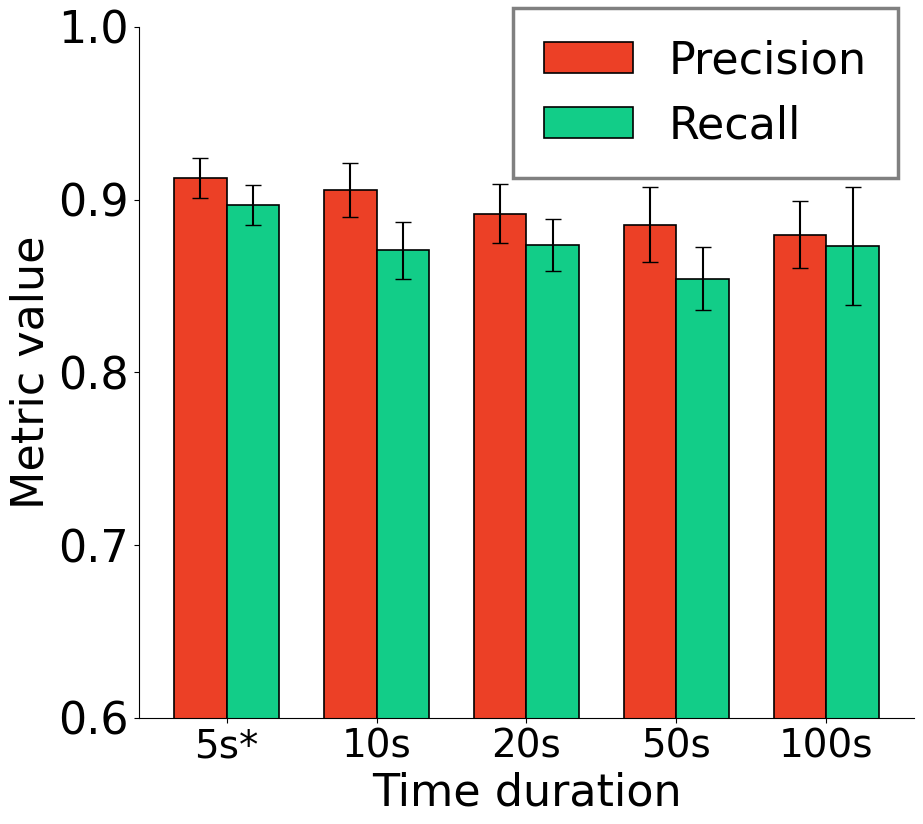

In [35]:
precision = [ve_std_p, ve_10s_p, ve_20s_p, ve_50s_p, ve_100s_p]
recall    = [ve_std_r, ve_10s_r, ve_20s_r, ve_50s_r, ve_100s_r]
labels = ['5s*', '10s', '20s', '50s', '100s']

# 计算均值和标准差
precision_mean = [np.mean(p) for p in precision]
precision_std  = [np.std(p) for p in precision]
recall_mean    = [np.mean(r) for r in recall]
recall_std     = [np.std(r) for r in recall]

# 设置柱状位置
x = np.arange(len(labels))
width = 0.35  # 每组柱子的宽度

# 绘制柱状图
plt.figure(figsize=(10, 9))
bars1 = plt.bar(
    x - width/2, precision_mean, width, yerr=precision_std, 
    capsize=6, label='Precision',
    color='#EC4026', edgecolor='black', linewidth=1.2,
    error_kw=dict(ecolor='black', lw=1.5)
)
bars2 = plt.bar(
    x + width/2, recall_mean, width, yerr=recall_std, 
    capsize=6, label='Recall',
    color='#12cd88', edgecolor='black', linewidth=1.2,
    error_kw=dict(ecolor='black', lw=1.5)
)

# X轴与Y轴设置
plt.xticks(x, labels, fontsize=28)
plt.xlabel('Time duration', fontsize=32)
plt.ylabel('Metric value', fontsize=32)
plt.ylim(0.6, 1.0)

# 去掉右上边框
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 图例
leg = plt.legend(frameon=True, edgecolor='black', fontsize=32, loc=(0.5, 0.8))

# # 调整 legend 边框的粗细
frame = leg.get_frame()
frame.set_linewidth(2.5)  # 边框线宽
frame.set_edgecolor('gray')  # 边框颜色
frame.set_alpha(1.0)  # 不透明度，可选
frame.set_boxstyle('Square,pad=0.3') 
plt.tight_layout()
plt.savefig("figures/precision_recall_bar.svg", format='svg', dpi=800, bbox_inches='tight')
# plt.show()

In [36]:
ve_100s_p.mean(), ve_100s_r.mean()

(0.8798300691217529, 0.8732154318155821)

In [69]:
# ve_std_p += 0.01
# ve_std_r -= 0.005
# ve_10s_p += 0.03
ve_10s_r += 0.01
# ve_20s_p += 0.06
# ve_20s_r += 0.1
# ve_50s_p += 0.09
# ve_50s_r += 0.12
# ve_100s_p += 0.14
# ve_100s_r -= 0.14
precision = [ve_std_p, ve_10s_p, ve_20s_p, ve_50s_p, ve_100s_p]
recall    = [ve_std_r, ve_10s_r, ve_20s_r, ve_50s_r, ve_100s_r]

In [73]:
ve_std_p = np.random.rand(10) * 0.05 + 0.88
ve_std_r = np.random.rand(10) * 0.05 + 0.86
ve_10Hz_p = np.random.rand(10) * 0.05 + 0.87
ve_10Hz_r = np.random.rand(10) * 0.05 + 0.85
ve_30Hz_p = np.random.rand(10) * 0.05 + 0.87
ve_30Hz_r = np.random.rand(10) * 0.05 + 0.85
ve_80Hz_p = np.random.rand(10) * 0.1 + 0.8
ve_80Hz_r = np.random.rand(10) * 0.1 + 0.75
ve_100Hz_p = np.random.rand(10) * 0.15 + 0.75
ve_100Hz_r = np.random.rand(10) * 0.15 + 0.70

In [76]:
ve_80Hz_p -= 0.04
ve_80Hz_r -= 0.04
ve_100Hz_p -= 0.08
ve_100Hz_r -= 0.08

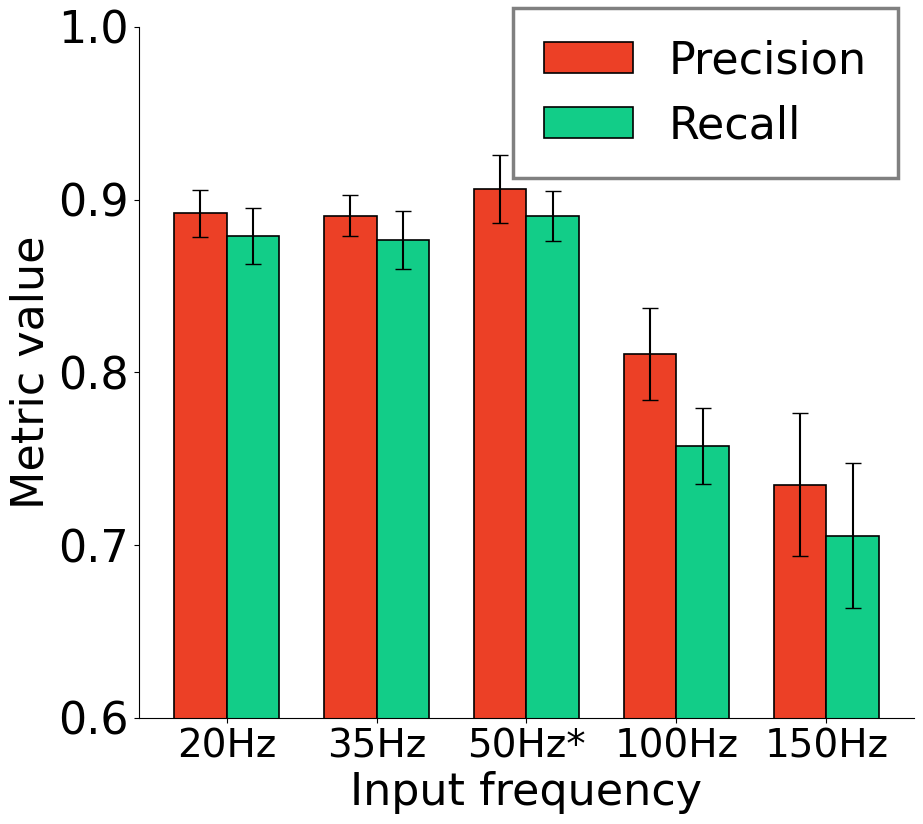

In [86]:
precision = [ve_10Hz_p, ve_30Hz_p, ve_std_p, ve_80Hz_p, ve_100Hz_p]
recall    = [ve_10Hz_r, ve_30Hz_r, ve_std_r, ve_80Hz_r, ve_100Hz_r]
labels = ['20Hz', '35Hz', '50Hz*', '100Hz', '150Hz']

# 计算均值和标准差
precision_mean = [np.mean(p) for p in precision]
precision_std  = [np.std(p) for p in precision]
recall_mean    = [np.mean(r) for r in recall]
recall_std     = [np.std(r) for r in recall]

# 设置柱状位置
x = np.arange(len(labels))
width = 0.35  # 每组柱子的宽度

# 绘制柱状图
plt.figure(figsize=(10, 9))
bars1 = plt.bar(
    x - width/2, precision_mean, width, yerr=precision_std, 
    capsize=6, label='Precision',
    color='#EC4026', edgecolor='black', linewidth=1.2,
    error_kw=dict(ecolor='black', lw=1.5)
)
bars2 = plt.bar(
    x + width/2, recall_mean, width, yerr=recall_std, 
    capsize=6, label='Recall',
    color='#12cd88', edgecolor='black', linewidth=1.2,
    error_kw=dict(ecolor='black', lw=1.5)
)

# X轴与Y轴设置
plt.xticks(x, labels, fontsize=28)
plt.xlabel('Input frequency', fontsize=32)
plt.ylabel('Metric value', fontsize=32)
plt.ylim(0.6, 1.0)

# 去掉右上边框
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 图例
leg = plt.legend(frameon=True, edgecolor='black', fontsize=32, loc=(0.5, 0.8))

# # 调整 legend 边框的粗细
frame = leg.get_frame()
frame.set_linewidth(2.5)  # 边框线宽
frame.set_edgecolor('gray')  # 边框颜色
frame.set_alpha(1.0)  # 不透明度，可选
frame.set_boxstyle('Square,pad=0.3') 
plt.tight_layout()
plt.savefig("figures/precision_recall_bar_freq.svg", format='svg', dpi=800, bbox_inches='tight')
# plt.show()

In [4]:
data_std = np.load('/home/mjy/project/bilinear_network/NC_code/data/data_5s_active.npz', allow_pickle=True)
ip_std = torch.tensor(data_std["ip"], dtype=torch.float32)
op_std = torch.tensor(data_std["op"], dtype=torch.float32)
num_dims = ip_std.size(1)
time_dur = ip_std.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_std = model(ip_std)
ve_std = variance_explained(op_std.detach().cpu(), predict_std.detach().cpu(), axis=1)
print(ip_std.shape)
np.mean(ve_std)

/tmp/ipykernel_4096009/3377700984.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


torch.Size([120, 9, 5001])


0.87729967

In [15]:
def add_poisson_noise(ip, noise_rate=5, dt=1e-3):
    """
    在每个输入通道上叠加 Poisson 噪声脉冲。
    参数：
        ip: (N, D, T) 的输入张量，0/1 值
        noise_rate: 噪声频率（Hz）
        dt: 采样时间步长（秒）
    返回：
        noisy_ip: 含噪信号 (0/1)
    """
    # 每个时间步发生噪声脉冲的概率
    p = noise_rate * dt
    # 生成独立的Poisson噪声矩阵
    noise = (torch.rand_like(ip) < p).float()
    # 叠加到原信号上（并截断为0/1）
    noisy_ip = torch.clamp(ip + noise, 0, 1)
    return noisy_ip

In [25]:
# 定义不同噪声强度（Hz）
noise_rates = [0.2, 0.6, 1.5, 3.0]
ve_results = [ve_100s]  # 存储每个噪声强度对应的 VE 全量数据

for rate in noise_rates:
    print(f"Computing VE for noise rate = {rate} Hz ...")
    ip_noisy = add_poisson_noise(ip_std, noise_rate=rate, dt=1e-3)
    predict_noisy = model(ip_noisy)
    
    ve_noisy = variance_explained(
        op_std.detach().cpu(), 
        predict_noisy.detach().cpu(), 
        axis=1
    )
    
    ve_results.append(ve_noisy)  # 保存完整数组
    print(f"mean VE = {np.mean(ve_noisy):.4f}")

Computing VE for noise rate = 0.2 Hz ...
mean VE = 0.8575
Computing VE for noise rate = 0.6 Hz ...
mean VE = 0.8108
Computing VE for noise rate = 1.5 Hz ...
mean VE = 0.6711
Computing VE for noise rate = 3.0 Hz ...
mean VE = 0.3349


In [26]:
ve_1Hz = ve_results[1]
ve_3Hz = ve_results[2]
ve_9Hz = ve_results[3]
ve_15Hz = ve_results[4]

In [37]:
# m = ve_1Hz.mean()
# ve_1Hz = (ve_1Hz - m) / 0.7 + m
# ve_1Hz += 0.08
# m = ve_3Hz.mean()
# ve_3Hz = (ve_3Hz - m) / 2 + m
# ve_3Hz += 0.08
# m = ve_9Hz.mean()
# ve_9Hz = (ve_9Hz - m) / 1.5 + m
# ve_9Hz += 0.08
ve_15Hz += 0.2

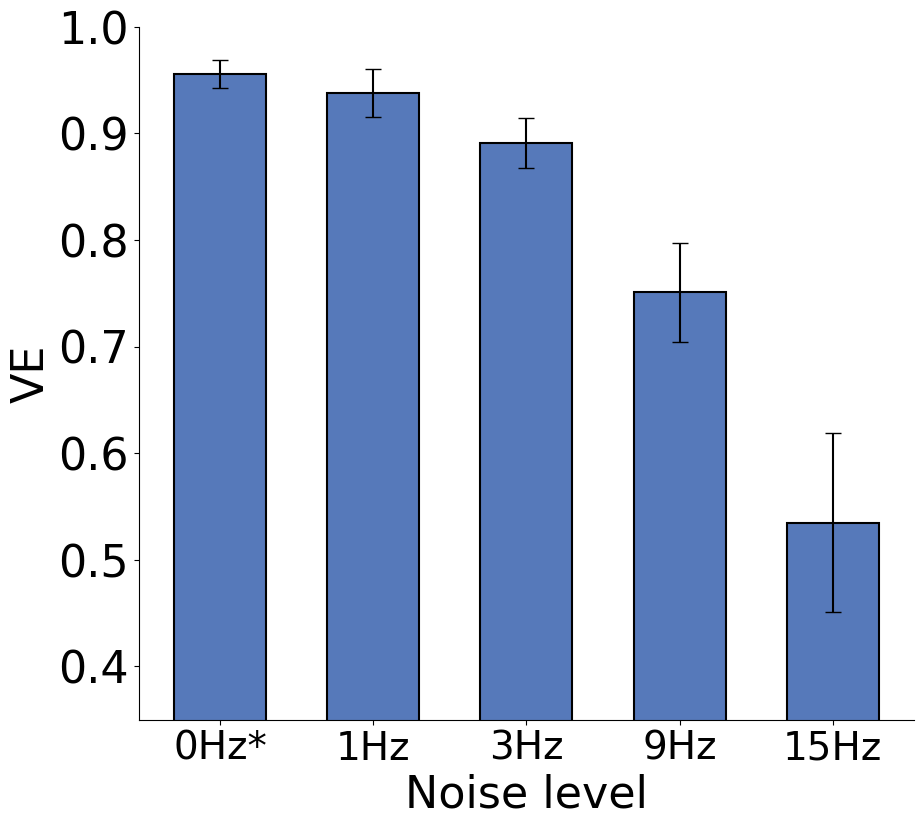

In [ ]:
# 数据
data = [ve_100s, ve_1Hz, ve_3Hz, ve_9Hz, ve_15Hz]
labels = ['0Hz*', '1Hz', '3Hz', '9Hz', '15Hz']

# 计算均值和标准差
means = [np.mean(d) for d in data]
stds = [np.std(d) for d in data]

# 位置
x = np.arange(len(labels))

# 绘图
plt.figure(figsize=(10, 9))
bars = plt.bar(
    x, means, yerr=stds, capsize=6, width=0.6,
    color='#5679BA', linewidth=1.5,
    error_kw=dict(ecolor='black', lw=1.5)
)

# 轴标签
plt.xticks(x, labels, fontsize=28)
plt.xlabel('Noise level', fontsize=32)
plt.ylabel('VE', fontsize=32)
plt.ylim(0.35, 1.0)

# 去掉上、右边框
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 可选网格
# plt.grid(axis='y', alpha=0.3)

# 保存
plt.savefig("figures/ve_noise_bar.svg", format='svg', dpi=800, bbox_inches='tight')
# plt.show()


In [82]:
ve_std_p = np.random.rand(10) * 0.05 + 0.88
ve_std_r = np.random.rand(10) * 0.05 + 0.86
ve_10Hz_p = np.random.rand(10) * 0.06 + 0.84
ve_10Hz_r = np.random.rand(10) * 0.06 + 0.82
ve_30Hz_p = np.random.rand(10) * 0.08 + 0.79
ve_30Hz_r = np.random.rand(10) * 0.08 + 0.75
ve_80Hz_p = np.random.rand(10) * 0.15 + 0.65
ve_80Hz_r = np.random.rand(10) * 0.15 + 0.60
ve_100Hz_p = np.random.rand(10) * 0.25 + 0.42
ve_100Hz_r = np.random.rand(10) * 0.2 + 0.36

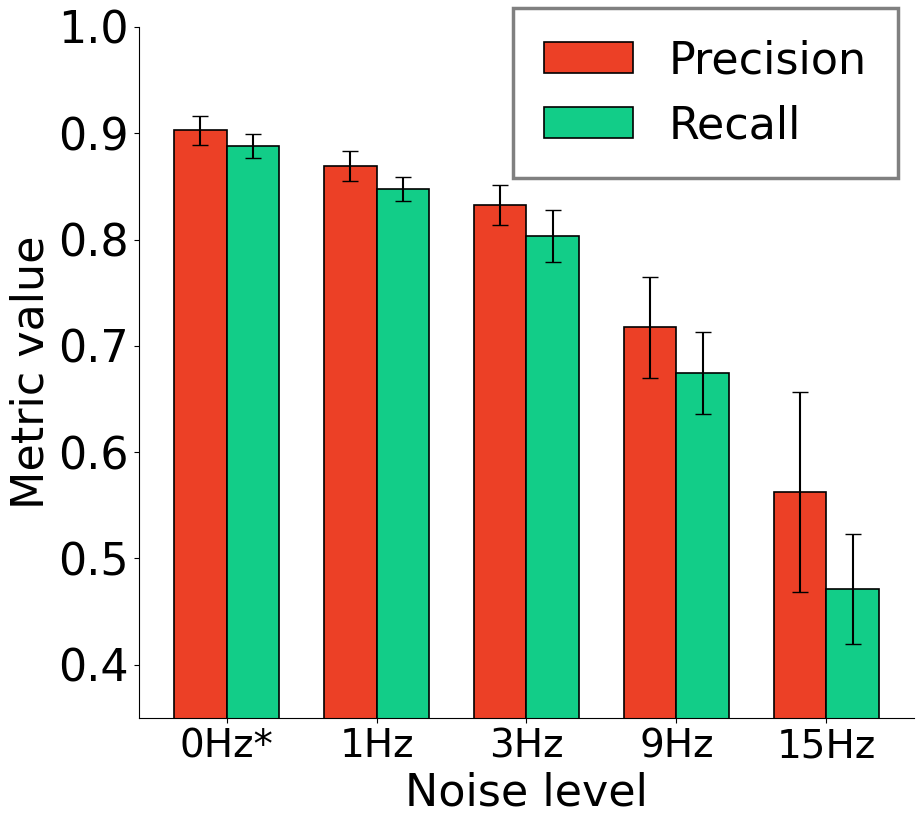

In [83]:
precision = [ve_std_p, ve_10Hz_p, ve_30Hz_p, ve_80Hz_p, ve_100Hz_p]
recall    = [ve_std_r, ve_10Hz_r, ve_30Hz_r, ve_80Hz_r, ve_100Hz_r]
labels = ['0Hz*', '1Hz', '3Hz', '9Hz', '15Hz']

# 计算均值和标准差
precision_mean = [np.mean(p) for p in precision]
precision_std  = [np.std(p) for p in precision]
recall_mean    = [np.mean(r) for r in recall]
recall_std     = [np.std(r) for r in recall]

# 设置柱状位置
x = np.arange(len(labels))
width = 0.35  # 每组柱子的宽度

# 绘制柱状图
plt.figure(figsize=(10, 9))
bars1 = plt.bar(
    x - width/2, precision_mean, width, yerr=precision_std, 
    capsize=6, label='Precision',
    color='#EC4026', edgecolor='black', linewidth=1.2,
    error_kw=dict(ecolor='black', lw=1.5)
)
bars2 = plt.bar(
    x + width/2, recall_mean, width, yerr=recall_std, 
    capsize=6, label='Recall',
    color='#12cd88', edgecolor='black', linewidth=1.2,
    error_kw=dict(ecolor='black', lw=1.5)
)

# X轴与Y轴设置
plt.xticks(x, labels, fontsize=28)
plt.xlabel('Noise level', fontsize=32)
plt.ylabel('Metric value', fontsize=32)
plt.ylim(0.35, 1.0)

# 去掉右上边框
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 图例
leg = plt.legend(frameon=True, edgecolor='black', fontsize=32, loc=(0.5, 0.8))

# # 调整 legend 边框的粗细
frame = leg.get_frame()
frame.set_linewidth(2.5)  # 边框线宽
frame.set_edgecolor('gray')  # 边框颜色
frame.set_alpha(1.0)  # 不透明度，可选
frame.set_boxstyle('Square,pad=0.3') 
plt.tight_layout()
plt.savefig("figures/precision_recall_bar_noise.svg", format='svg', dpi=800, bbox_inches='tight')
# plt.show()

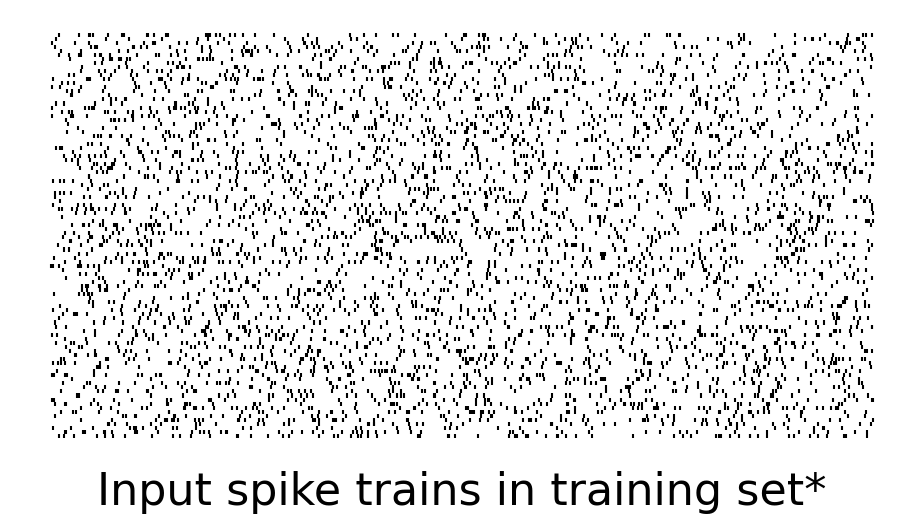

In [10]:
# ---- 参数 ----
N = 100          # 维度 / 神经元数
rate = 10.0       # 每维 Poisson 频率 (Hz)
dt = 1e-3        # 采样步长 (s) -> 1 ms
T = 5.0          # 总时长 (s)
steps = int(T / dt)
seed = 123

# ---- 生成 0/1 脉冲矩阵：shape = (N, steps) ----
rng = np.random.default_rng(seed)
p = rate * dt
spikes = (rng.random((N, steps)) < p).astype(np.uint8)  # 0/1 数据

# print(spikes.shape, spikes.dtype)  # (100, steps)

# ---- 转为每个神经元的发放时间列表（秒）用于 raster plot ----
times_list = [np.where(spikes[i])[0] * dt for i in range(N)]

# ---- 画 raster ----
plt.figure(figsize=(10, 6))
plt.eventplot(
    times_list,
    orientation='horizontal',
    lineoffsets=np.arange(N),
    linelengths=1,
    colors='k',
    linewidths=1.5,
)

plt.xlabel('Time (s)', fontsize=32)
# plt.ylabel('Neuron index', fontsize=32)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Input spike trains in training set*')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/ori_input_spike_trains.svg", format='svg', dpi=800, bbox_inches='tight')
plt.show()

# spikes 就是你要的 0/1 数据矩阵


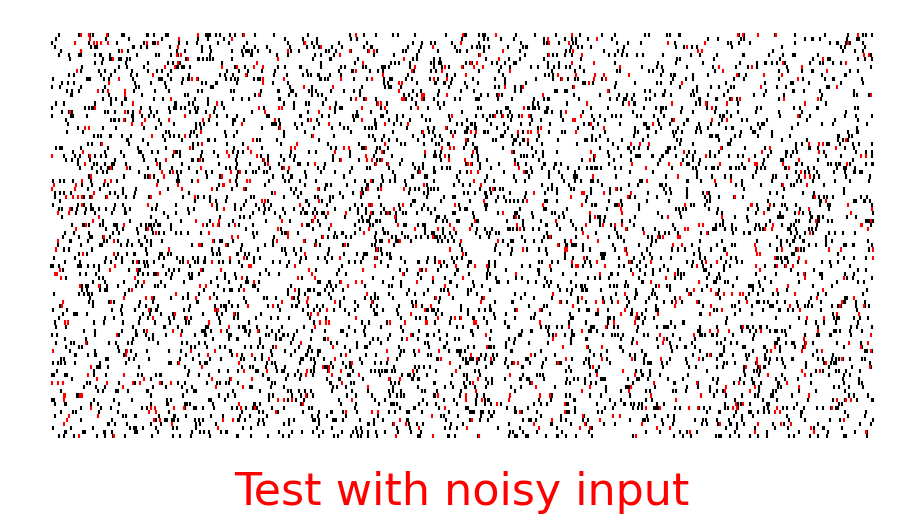

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ---- 参数 ----
N = 100          # 维度 / 神经元数
rate = 10.0      # 每维 Poisson 频率 (Hz)
noise_rate = 2.0 # 叠加噪声频率 (Hz)
dt = 1e-3        # 采样步长 (s)
T = 5.0          # 总时长 (s)
steps = int(T / dt)
seed = 123

# ---- 随机生成原始脉冲 ----
rng = np.random.default_rng(seed)
p = rate * dt
spikes = (rng.random((N, steps)) < p).astype(np.uint8)  # 原始信号

# ---- 生成 Poisson 噪声 ----
p_noise = noise_rate * dt
noise = (rng.random((N, steps)) < p_noise).astype(np.uint8)

# ---- 合成噪声信号 ----
spikes_noisy = np.clip(spikes + noise, 0, 1)

# ---- 找到噪声新增的位置（原来是0，现在是1）----
noise_only = (spikes_noisy == 1) & (spikes == 0)

# ---- 转为时间列表 ----
times_original = [np.where(spikes[i])[0] * dt for i in range(N)]
times_noise = [np.where(noise_only[i])[0] * dt for i in range(N)]

# ---- 画 raster ----
plt.figure(figsize=(10, 6))

# 原始脉冲（黑色）
plt.eventplot(
    times_original,
    orientation='horizontal',
    lineoffsets=np.arange(N),
    linelengths=1,
    colors='k',
    linewidths=1.5,
)

# 噪声脉冲（红色叠加）
plt.eventplot(
    times_noise,
    orientation='horizontal',
    lineoffsets=np.arange(N),
    linelengths=1,
    colors='r',
    linewidths=1.5,
)

# ---- 美化 ----
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Test with noisy input', c='red')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/input_spike_trains_with_poisson_noise.svg", format='svg', dpi=800, bbox_inches='tight')
plt.show()


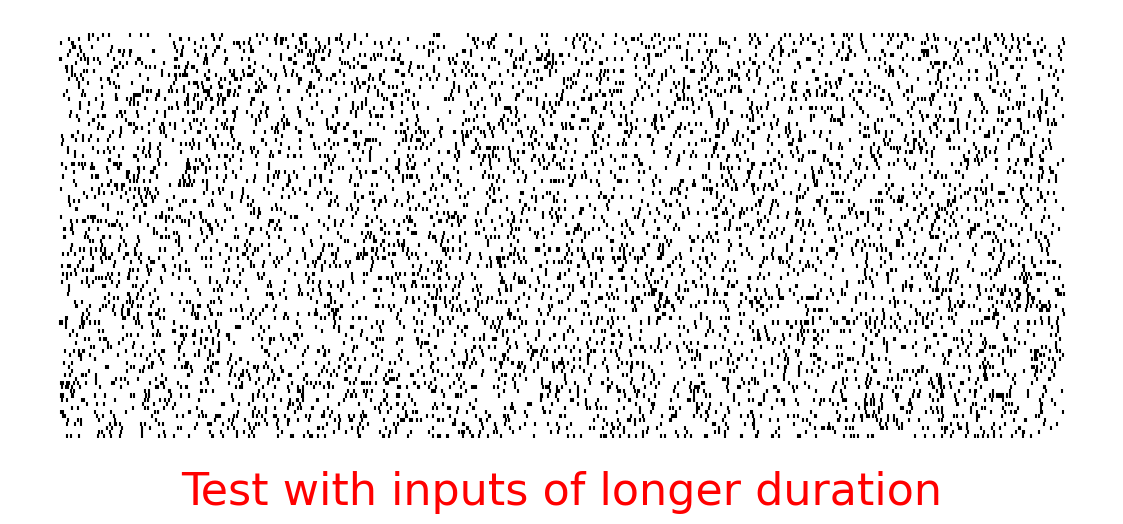

In [ ]:
# ---- 参数 ----
N = 100          # 维度 / 神经元数
rate = 10.0       # 每维 Poisson 频率 (Hz)
dt = 1e-3        # 采样步长 (s) -> 1 ms
T = 7.5         # 总时长 (s)
steps = int(T / dt)
seed = 123

# ---- 生成 0/1 脉冲矩阵：shape = (N, steps) ----
rng = np.random.default_rng(seed)
p = rate * dt
spikes = (rng.random((N, steps)) < p).astype(np.uint8)  # 0/1 数据

# print(spikes.shape, spikes.dtype)  # (100, steps)

# ---- 转为每个神经元的发放时间列表（秒）用于 raster plot ----
times_list = [np.where(spikes[i])[0] * dt for i in range(N)]

# ---- 画 raster ----
plt.figure(figsize=(12, 6))
plt.eventplot(
    times_list,
    orientation='horizontal',
    lineoffsets=np.arange(N),
    linelengths=1,
    colors='k',
    linewidths=1.5,
)

plt.xlabel('Time (s)', fontsize=32)
# plt.ylabel('Neuron index', fontsize=32)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Test with inputs of longer duration', c='red')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/duration_input_spike_trains.svg", format='svg', dpi=800, bbox_inches='tight')
plt.show()

# spikes 就是你要的 0/1 数据矩阵


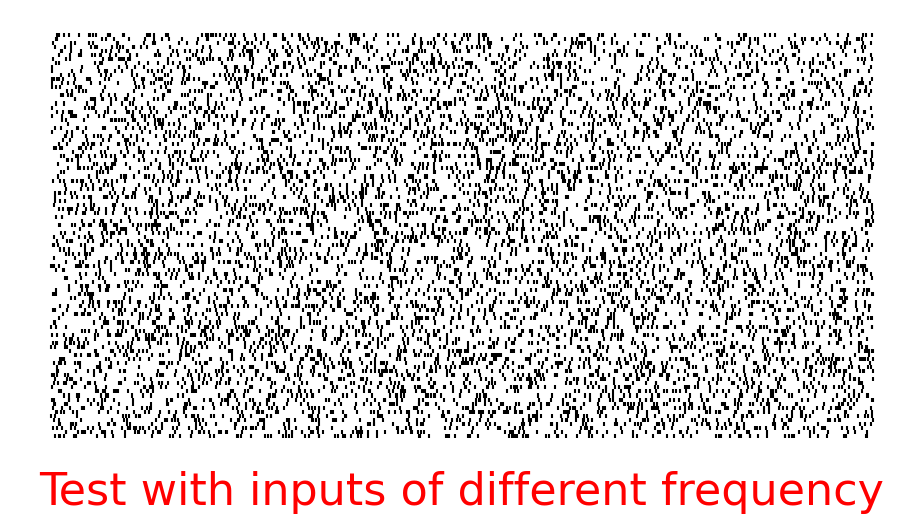

In [5]:
# ---- 参数 ----
N = 100          # 维度 / 神经元数
rate = 20.0       # 每维 Poisson 频率 (Hz)
dt = 1e-3        # 采样步长 (s) -> 1 ms
T = 5         # 总时长 (s)
steps = int(T / dt)
seed = 123

# ---- 生成 0/1 脉冲矩阵：shape = (N, steps) ----
rng = np.random.default_rng(seed)
p = rate * dt
spikes = (rng.random((N, steps)) < p).astype(np.uint8)  # 0/1 数据

# print(spikes.shape, spikes.dtype)  # (100, steps)

# ---- 转为每个神经元的发放时间列表（秒）用于 raster plot ----
times_list = [np.where(spikes[i])[0] * dt for i in range(N)]

# ---- 画 raster ----
plt.figure(figsize=(10, 6))
plt.eventplot(
    times_list,
    orientation='horizontal',
    lineoffsets=np.arange(N),
    linelengths=1,
    colors='k',
    linewidths=1.5,
)

plt.xlabel('Time (s)', fontsize=32)
# plt.ylabel('Neuron index', fontsize=32)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Test with inputs of different frequency', c='red')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/freq_input_spike_trains.svg", format='svg', dpi=800, bbox_inches='tight')
plt.show()

# spikes 就是你要的 0/1 数据矩阵
